In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 20b

## Regression using RNN LSTM
</p><img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

### Data Location 
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

**Attribute Information:**

1. date: Date in format dd/mm/yyyy 
2. time: time in format hh:mm:ss 
3. global_active_power: household global minute-averaged active power (in kilowatt) 
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
5. voltage: minute-averaged voltage (in volt) 
6. global_intensity: household global minute-averaged current intensity (in ampere) 
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


In [2]:
# Import the packages
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

import tensorflow as tf

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-16 21:03:03.865273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 21:03:03.908123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 21:03:03.908296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
inpDir = '../input'
subDir = 'housing'
outDir = '../output'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well/

EPOCHS = 80

BATCH_SIZE = 32

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams

# Importing the data and data processing

In [5]:
df = pd.read_csv(os.path.join(inpDir, 'housing','household_power_consumption.txt'),
                 sep=';',  # semicolon separated 
                 parse_dates={'dt' : ['Date', 'Time']}, # combine date and time columns and create a time stamp
                 infer_datetime_format=True,  # automatic conversion of time stamp
                 low_memory=False,
                 na_values=['nan','?'], # how to handle ? and nan string
                 index_col='dt') # indexed by timestamp

In [6]:
df.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [8]:
df.shape

(2075259, 7)

In [9]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [10]:
# Check the columns
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [11]:
for col in df.columns:
       print('In Column: {} \n {}\n\n'.format(col, df[col].unique()))

In Column: Global_active_power 
 [4.216 5.36  5.374 ... 9.63  9.648 8.6  ]


In Column: Global_reactive_power 
 [0.418 0.436 0.498 0.502 0.528 0.522 0.52  0.51  0.47  0.478 0.398 0.422
 0.282 0.152 0.156 0.    0.076 0.09  0.2   0.058 0.18  0.144 0.118 0.108
 0.202 0.192 0.186 0.116 0.136 0.148 0.16  0.158 0.1   0.082 0.05  0.052
 0.162 0.086 0.048 0.054 0.068 0.166 0.174 0.178 0.188 0.088 0.08  0.07
 0.084 0.074 0.106 0.092 0.064 0.046 0.138 0.134 0.132 0.12  0.13  0.154
 0.078 0.142 0.14  0.146 0.15  0.17  0.102 0.072 0.06  0.056 0.062 0.112
 0.066 0.172 0.168 0.194 0.184 0.096 0.164 0.182 0.094 0.098 0.176 0.19
 0.204 0.22  0.198 0.208 0.244 0.334 0.298 0.296 0.286 0.278 0.104 0.258
 0.238 0.256 0.214 0.23  0.21  0.24  0.124 0.122 0.27  0.302 0.272 0.25
 0.294 0.3   0.128 0.126 0.234 0.242 0.316 0.28  0.288 0.224 0.11  0.248
 0.254 0.222 0.246 0.216 0.212 0.114 0.206 0.228 0.226 0.196 0.218 0.368
 0.338 0.31  0.304 0.292 0.268 0.266 0.26  0.396 0.38  0.4   0.384 0.416
 0.404 0.382 0.

##  Clean up  missing values  'nan' with mean

In [12]:
# filling nan with mean in any columns

df = df.fillna(df.mean())

In [13]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# LSTM Data Preparation and feature engineering

This supervised learning problem will be formulated as predicting the `Global_active_power` at the current time (t) given the `Global_active_power` measurement and other features at the prior time step.

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    
    dff = pd.DataFrame(data)
    
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        
        cols.append(dff.shift(i))
        
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        
        cols.append(dff.shift(-i))
        
        if i == 0:
            
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    
    agg.columns = names
    
    # drop rows with NaN values
    
    if dropnan:
        
        agg.dropna(inplace=True)
    
    return agg
 

* In order to reduce the computation time, and also get a quick result to test the model.  One can resample the data over hour (the original data are given in minutes). This will reduce the size of data from 2075259 to 34589 but keep the overall structure of data.   

In [15]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

Note: Scale all features in range of [0,1]. 

In [16]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_resample)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [17]:
scaled.shape

(34589, 7)

In [18]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723


In [19]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


* Above has 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current  time in hour (depending on resampling). 

* Splitting the data to train and validation sets

In [20]:
n_train_time = 365*24
train = reframed.iloc[:n_train_time]
test = reframed.iloc[n_train_time:]
reframed.shape, train.shape, test.shape

((34588, 8), (8760, 8), (25828, 8))

In [21]:
y_train = train[['var1(t)']].values
X_train = train.drop('var1(t)', axis = 1).values

y_test = test[['var1(t)']].values
X_test = test.drop('var1(t)', axis = 1).values
X_test.shape

(25828, 7)

Need to reshape the inputs into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

In [22]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 


(8760, 1, 7) (8760, 1) (25828, 1, 7) (25828, 1)


# Model Architecture

1. LSTM with 100 neurons in the first visible layer 
2. dropout 20%
4. Dense layer with 50 neurons
5. 1 neuron in the output layer for predicting Global_active_power. 
6. The input shape will be 1 time step with 7 features.
7. Use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
8. The model will be fit for 100 training epochs with a batch size of 32.

In [23]:
model = tf.keras.Sequential()
initializer = tf.keras.initializers.HeNormal()
model.add(tf.keras.layers.LSTM(256,
                               activation='tanh',
                               kernel_initializer=initializer,
                               input_shape=(X_train.shape[1],
                                            X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(50))

model.add(tf.keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

2022-06-16 21:03:09.092908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 21:03:09.094004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 21:03:09.094179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 21:03:09.094285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

> tf.keras.layers.LSTM(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, time_major=False,
    unroll=False, **kwargs
)

## Arguments: 
Arguments|Description
:--|:--
units|Positive integer, dimensionality of the output space.
activation|Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
recurrent_activation|Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
use_bias|Boolean (default True), whether the layer uses a bias vector.
kernel_initializer|Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.
recurrent_initializer|Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
bias_initializer|Initializer for the bias vector. Default: zeros.
unit_forget_bias|Boolean (default True). If True, add 1 to the bias of the forget gate at initialization. Setting it to true will also force bias_initializer="zeros". This is recommended in Jozefowicz et al..
kernel_regularizer|Regularizer function applied to the kernel weights matrix. Default: None.
recurrent_regularizer|Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
bias_regularizer|Regularizer function applied to the bias vector. Default: None.
activity_regularizer|Regularizer function applied to the output of the layer (its "activation"). Default: None.
kernel_constraint|Constraint function applied to the kernel weights matrix. Default: None.
recurrent_constraint|Constraint function applied to the recurrent_kernel weights matrix. Default: None.
bias_constraint|Constraint function applied to the bias vector. Default: None.
dropout|Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
recurrent_dropout|Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
implementation|Implementation mode, either 1 or 2. Mode 1 will structure its operations as a larger number of smaller dot products and additions, whereas mode 2 will batch them into fewer, larger operations. These modes will have different performance profiles on different hardware and for different applications. Default: 2.
return_sequences|Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.
return_state|Boolean. Whether to return the last state in addition to the output. Default: False.
go_backwards|Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
stateful|Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
time_major|The shape format of the inputs and outputs tensors. If True, the inputs and outputs will be in shape [timesteps, batch, feature], whereas in the False case, it will be [batch, timesteps, feature]. Using time_major = True is a bit more efficient because it avoids transposes at the beginning and end of the RNN calculation. However, most TensorFlow data is batch-major, so by default this function accepts input and emits output in batch-major form.
unroll|Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences. 

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               270336    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 283,237
Trainable params: 283,237
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit network
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/80


2022-06-16 21:03:11.892400: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-06-16 21:03:12.015878: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


274/274 - 5s - loss: 0.0151 - val_loss: 0.0137 - 5s/epoch - 20ms/step
Epoch 2/80
274/274 - 3s - loss: 0.0116 - val_loss: 0.0127 - 3s/epoch - 11ms/step
Epoch 3/80
274/274 - 3s - loss: 0.0113 - val_loss: 0.0114 - 3s/epoch - 10ms/step
Epoch 4/80
274/274 - 3s - loss: 0.0110 - val_loss: 0.0116 - 3s/epoch - 11ms/step
Epoch 5/80
274/274 - 3s - loss: 0.0108 - val_loss: 0.0107 - 3s/epoch - 10ms/step
Epoch 6/80
274/274 - 3s - loss: 0.0108 - val_loss: 0.0100 - 3s/epoch - 11ms/step
Epoch 7/80
274/274 - 3s - loss: 0.0106 - val_loss: 0.0092 - 3s/epoch - 11ms/step
Epoch 8/80
274/274 - 3s - loss: 0.0106 - val_loss: 0.0091 - 3s/epoch - 11ms/step
Epoch 9/80
274/274 - 3s - loss: 0.0105 - val_loss: 0.0086 - 3s/epoch - 11ms/step
Epoch 10/80
274/274 - 3s - loss: 0.0105 - val_loss: 0.0089 - 3s/epoch - 12ms/step
Epoch 11/80
274/274 - 3s - loss: 0.0105 - val_loss: 0.0089 - 3s/epoch - 12ms/step
Epoch 12/80
274/274 - 3s - loss: 0.0104 - val_loss: 0.0089 - 3s/epoch - 11ms/step
Epoch 13/80
274/274 - 3s - loss: 0.0

In [26]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

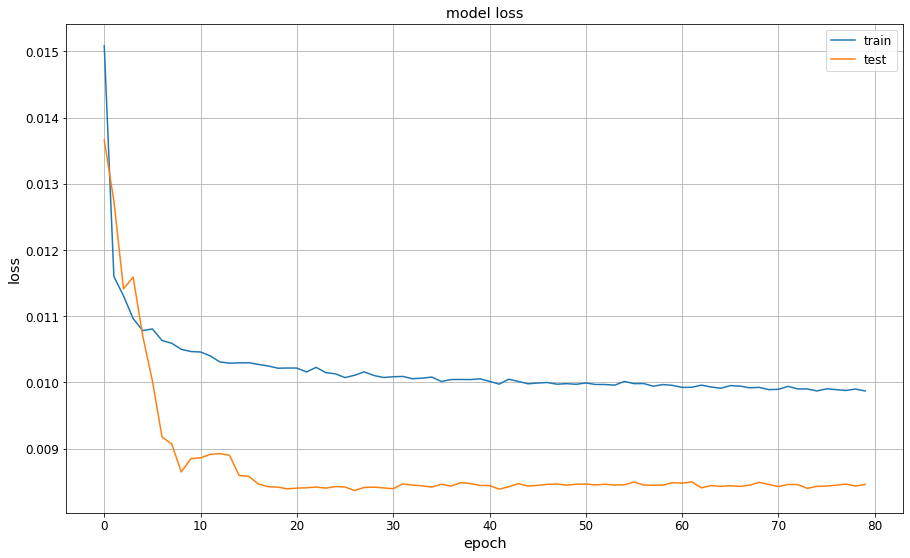

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

## Making Predictions

In [28]:
y_pred = model.predict(X_test)

808/808 [==============================] - 2s 2ms/step


In [29]:
# lets scale the X_test to 
X_test = X_test.reshape((X_test.shape[0], 7))
X_test[:2, :]

array([[0.36525355, 0.08458889, 0.47831591, 0.35341942, 0.        ,
        0.00897344, 0.80897138],
       [0.38881696, 0.05484288, 0.45310572, 0.37625538, 0.        ,
        0.        , 0.80433101]])

In [30]:
# inv scale pred
inv_x = np.concatenate((y_pred, X_test[:, -6:]), axis=1)
inv_x = scaler.inverse_transform(inv_x)
inv_y_pred = inv_x[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [31]:
inv_y_pred.shape, inv_y.shape

((25828,), (25828,))

In [32]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_pred))
print('Test RMSE    : %.3f' % rmse)
r2score = r2_score(inv_y, inv_y_pred)
print('Test R2 Score: %.3f' % r2score)
#Test RMSE    : 0.592
#Test R2 Score: 0.517

Test RMSE    : 0.592
Test R2 Score: 0.517


In [33]:
res_df = pd.DataFrame({'Global_active_power': inv_y, 'Pred':inv_y_pred})
res_df.head()

,Global_active_power,Pred
0,2.626633,2.244929
1,2.834200,2.307380
2,3.767167,2.721246
3,2.361233,2.640019
4,0.414667,1.813452


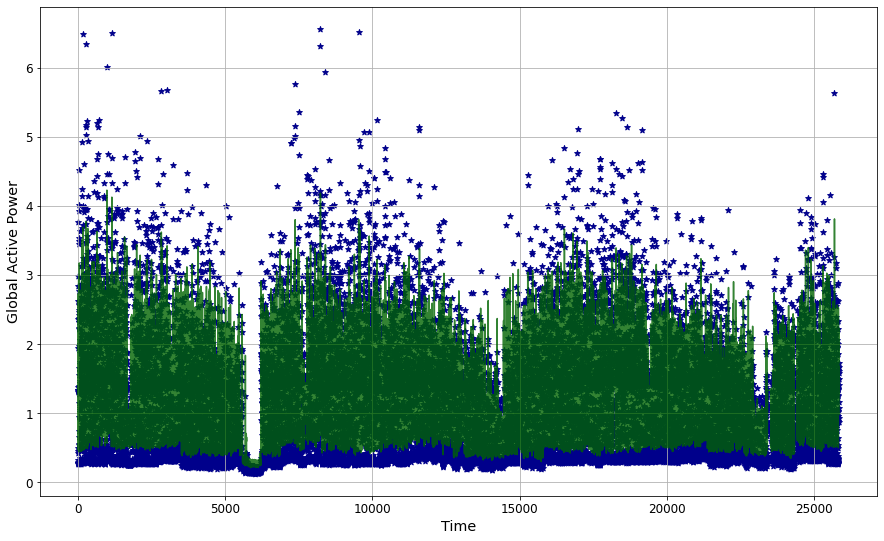

In [34]:
ax = res_df.Pred.plot(c = 'DarkGreen', alpha=0.8);
plt.scatter(res_df.index, res_df.Global_active_power, c='DarkBlue', marker ='*');
ax.set_xlabel("Time")
ax.set_ylabel("Global Active Power")
ax.grid()
plt.show()
